In [ ]:
## if using Domino's ray, start ray this way

import ray
import os

if ray.is_initialized() == False:
   service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
   service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
   ray.util.connect(f"{service_host}:{service_port}")

In [1]:
## if using on laptop do the following

!pip install --user ray==1.7
!pip install --user sync
!pip install --user aioredis==1.3.0

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
  Created wheel for sync: filename=sync-1.0.0-py3-none-any.whl size=5348 sha256=6e4690b6f783da9a2595131f83b5cbc82cc46ec94936efa946ed75758ab51dd7
  Stored in directory: /home/ubuntu/.cache/pip/wheels/16/6a/7e/727a2ff5f6d5cbf52fde2d7466bdee34f7a177d540b58dbb8b
Successfully built sync
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

In [3]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)


class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [4]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [6]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio



def create_env(config):
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 100

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)

In [7]:
local_dir = '/mnt/data/Optiver_Realized_Volatility_Prediction_Challenge'

analysis = tune.run(
    "DQN",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter"
    },
    checkpoint_at_end=True,
    checkpoint_freq = 1,
    local_dir = local_dir
)

2021-10-20 17:51:47,032	INFO services.py:1250 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-20 17:51:47,035	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67059712 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=8.45gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Trial name,status,loc
DQN_TradingEnv_66222_00000,PENDING,


2021-10-20 17:51:49,153	ERROR syncer.py:73 -- Log sync requires rsync to be installed.
(pid=2237) 2021-10-20 17:51:51,900	INFO dqn.py:141 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.


Trial name,status,loc
DQN_TradingEnv_66222_00000,RUNNING,


(pid=2242) 2021-10-20 17:51:54,872	INFO rollout_worker.py:1540 -- Validating sub-env at vector index=0 ... (ok)
(pid=2242) 2021-10-20 17:51:54,872	DEBUG rollout_worker.py:1363 -- Creating policy for default_policy
(pid=2242) 2021-10-20 17:51:54,876	DEBUG catalog.py:702 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f59a7c2d5b0>: Box([[-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-inf -inf -inf -inf -inf]
(pid=2242)  [-i

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 1000
  custom_metrics: {}
  date: 2021-10-20_17-51-56
  done: false
  episode_len_mean: .nan
  episode_media: {}
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 1000
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.1
          grad_gnorm: 5.823711395263672
          max_q: 1.3568369150161743
          mean_q: 0.45373502373695374
          min_q: -0.8455347418785095
        mean_td_error: 0.6412350535392761
        model: {}
        td_error: "[ 0.7646805   1.8567561   0.20838559 -1.1977346   1.7954868  -1.008977\n\
          \  2.1355534  -1.0147545  -0.86278737  2.229156    0.17002761  1.3865438\n\
          \  1.9644325   1.733

(pid=2237) 2021-10-20 17:51:56,432	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:56,450	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=1002, mean_mean=85.84234398861695, mean_std=28.926919586861207), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=2237) 2021-10-20 17:51:56,605	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:56,631	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:56,658	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:56,684	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:56,711	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:56,736	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:56,769	DEBUG train_ops.py:183 -- == sgd epochs 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,1,1.48693,1000,nan,nan,nan,nan


(pid=2237) 2021-10-20 17:51:59,671	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:59,695	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:59,720	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:59,744	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:59,769	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:59,796	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:59,819	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:51:59,833	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=2004, mean_mean=85.53116539469643, mean_std=28.822240317612554), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=2237) 2021-10-20 17:51:59,976	DEBUG train_ops.py:183 -- == sgd epochs 

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 3000
  custom_metrics: {}
  date: 2021-10-20_17-52-03
  done: false
  episode_len_mean: 707.75
  episode_media: {}
  episode_reward_max: 129.987556939018
  episode_reward_mean: 52.71285771838063
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 4
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 2512
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.0008008000000000001
          grad_gnorm: 0.7223318815231323
          max_q: 1.6125054359436035
          mean_q: -0.15847709774971008
          min_q: -1.6021735668182373
        mean_td_error: -0.15847709774971008
        model: {}
        td_error: "[-0.6269237  -0.1210798  -0.26609266  0.24141216 -0.4964478  -0.44101018\n\
          \  0.61250544 -0.31071103  0.20421147  0.

(pid=2237) 2021-10-20 17:52:03,412	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,437	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,466	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,491	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,515	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,543	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,572	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,595	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,619	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03,642	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:03

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,3,8.0194,3000,52.7129,129.988,-8.56713,707.75


(pid=2237) 2021-10-20 17:52:05,348	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,377	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,403	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,426	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,455	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,480	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,509	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,534	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,559	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05,583	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:05

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 5000
  custom_metrics: {}
  date: 2021-10-20_17-52-10
  done: false
  episode_len_mean: 805.1666666666666
  episode_media: {}
  episode_reward_max: 233.7584105709447
  episode_reward_mean: 109.73760727491565
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 6
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 4528
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.0006008000000000001
          grad_gnorm: 0.1895863115787506
          max_q: 1.3106791973114014
          mean_q: 0.24162083864212036
          min_q: -1.4453542232513428
        mean_td_error: 0.05412081629037857
        model: {}
        td_error: "[-4.4535422e-01 -2.1514553e-01 -8.1090868e-02  1.0771680e-01\n  9.9585599e-01\
          \  8.1187606e-02  2.3754394

(pid=2237) 2021-10-20 17:52:10,383	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,409	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,434	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,459	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,483	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,506	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,530	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,553	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,576	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10,600	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:10

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,5,14.718,5000,109.738,233.758,-8.56713,805.167


(pid=2237) 2021-10-20 17:52:11,306	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,330	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,355	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,386	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,416	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,443	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,469	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,494	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,523	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11,552	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:11

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,6,17.9187,6000,109.738,233.758,-8.56713,805.167


(pid=2237) 2021-10-20 17:52:16,681	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,711	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,739	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,763	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,788	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,812	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,836	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,861	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,884	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16,912	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:16

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 7000
  custom_metrics: {}
  date: 2021-10-20_17-52-17
  done: false
  episode_len_mean: 853.875
  episode_media: {}
  episode_reward_max: 344.0656076126166
  episode_reward_mean: 166.98877083923782
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 8
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 6544
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.0004008
          grad_gnorm: 0.18301251530647278
          max_q: 1.2636408805847168
          mean_q: 0.24798327684402466
          min_q: -1.388633370399475
        mean_td_error: 0.060483284294605255
        model: {}
        td_error: "[ 0.08522689  0.06701756 -0.209826   -0.18862534  0.38778418 -0.38863337\n\
          \  0.19915235 -0.44853747  0.2373091   0.18937755 -

(pid=2237) 2021-10-20 17:52:17,241	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,272	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,299	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,326	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,354	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,377	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,403	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,426	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,450	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17,479	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:17

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,8,24.5249,8000,166.989,344.066,-8.56713,853.875


(pid=2237) 2021-10-20 17:52:22,572	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,598	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,623	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,647	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,672	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,697	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,728	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,754	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,779	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22,802	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:22

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 9000
  custom_metrics: {}
  date: 2021-10-20_17-52-23
  done: false
  episode_len_mean: 883.1
  episode_media: {}
  episode_reward_max: 470.5413936980703
  episode_reward_mean: 224.83070757522182
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 10
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 8560
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 0.0002008
          grad_gnorm: 0.14601564407348633
          max_q: 1.3037219047546387
          mean_q: 0.7374994158744812
          min_q: -1.074674367904663
        mean_td_error: 0.04999936372041702
        model: {}
        td_error: "[ 0.0908463   0.13470471  0.02314639 -0.08862311 -0.54936814  0.10545969\n\
          \ -0.01260173  0.04970765 -0.01252007  0.10961747 -0.0

(pid=2237) 2021-10-20 17:52:24,039	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,068	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,094	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,119	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,149	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,174	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,200	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,225	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,249	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24,272	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:24

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,10,30.9537,10000,224.831,470.541,-8.56713,883.1


(pid=2237) 2021-10-20 17:52:28,254	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,283	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,311	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,336	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,361	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,385	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,411	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,434	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,459	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28,635	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:28

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 11000
  custom_metrics: {}
  date: 2021-10-20_17-52-30
  done: false
  episode_len_mean: 902.5833333333334
  episode_media: {}
  episode_reward_max: 558.2695872968686
  episode_reward_mean: 280.2458759810864
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 12
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 10576
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.900800000000001e-05
          grad_gnorm: 0.06483683735132217
          max_q: 1.0955677032470703
          mean_q: 0.41499456763267517
          min_q: -1.3409289121627808
        mean_td_error: 0.03999457508325577
        model: {}
        td_error: "[-0.32106996 -0.5023074  -0.03021252  0.03511381 -0.7009487   0.16983497\n\
          \ -0.00835019 -0.3260913   


(pid=2237) 2021-10-20 17:52:30,615	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,638	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,665	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,690	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,713	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,736	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,763	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,788	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,813	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:30,837	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:3

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,11,34.1712,11000,280.246,558.27,-8.56713,902.583


(pid=2237) 2021-10-20 17:52:33,521	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,544	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,568	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,592	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,614	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,638	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,660	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,683	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,706	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:33,721	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 13000
  custom_metrics: {}
  date: 2021-10-20_17-52-36
  done: false
  episode_len_mean: 916.5
  episode_media: {}
  episode_reward_max: 583.9325318092665
  episode_reward_mean: 323.3048602826871
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 14
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 12592
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.7008e-05
          grad_gnorm: 0.22643111646175385
          max_q: 1.2068753242492676
          mean_q: 0.8254950046539307
          min_q: -1.0227551460266113
        mean_td_error: -0.01825506053864956
        model: {}
        td_error: "[-0.00896502  0.20687532  0.1203655  -0.0521102   0.06797791 -0.24142814\n\
          \ -0.02604282  0.04062176 -0.0616644   0.01425397 

(pid=2237) 2021-10-20 17:52:37,040	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,065	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,089	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,117	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,141	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,165	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,191	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,222	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,246	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37,274	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:37

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,13,40.4046,13000,323.305,583.933,-8.56713,916.5


(pid=2237) 2021-10-20 17:52:39,007	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,032	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,056	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,082	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,107	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,132	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,159	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,183	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,207	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39,232	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:39

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 15000
  custom_metrics: {}
  date: 2021-10-20_17-52-43
  done: false
  episode_len_mean: 926.9375
  episode_media: {}
  episode_reward_max: 585.0389136047336
  episode_reward_mean: 355.9132289319152
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 16
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 14608
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.500800000000001e-05
          grad_gnorm: 0.20419500768184662
          max_q: 1.1313425302505493
          mean_q: 0.529642641544342
          min_q: -1.32985258102417
        mean_td_error: 0.029642626643180847
        model: {}
        td_error: "[ 0.0340209  -0.40760136  0.3197341   0.05564487 -0.16951203 -0.03913486\n\
          \ -0.01392835 -0.6003494   0.00775099  

(pid=2237) 2021-10-20 17:52:43,583	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,606	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,629	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,651	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,673	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,698	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,720	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,743	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,765	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43,788	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:43

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,15,46.6814,15000,355.913,585.039,-8.56713,926.938


(pid=2237) 2021-10-20 17:52:44,501	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,529	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,555	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,577	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,600	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,625	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,648	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,671	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,699	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44,727	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:44

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,16,49.7263,16000,355.913,585.039,-8.56713,926.938


(pid=2237) 2021-10-20 17:52:49,552	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,575	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,598	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,622	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,646	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,670	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,686	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=17020, mean_mean=80.56266230641499, mean_std=28.423730348365638), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 17000
  custom_metrics: {}
  date: 2021-10-20_17-52-49
  done: false
  episode_len_mean: 935.0555555555555
  episode_media: {}
  episode_reward_max: 585.0389136047336
  episode_reward_mean: 380.9534223995022
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 18
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 16624
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.3008e-05
          grad_gnorm: 0.23776322603225708
          max_q: 1.1732484102249146
          mean_q: 0.6010807156562805
          min_q: -1.178503394126892
        mean_td_error: -0.0239192396402359
        model: {}
        td_error: "[ 0.12769353  0.02248001  0.13030928  0.3048017  -0.51397943  0.16125536\n\
          \  0.03254282 -0.87239    -0.18456846 -0

(pid=2237) 2021-10-20 17:52:49,802	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,829	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,853	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,880	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,905	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,936	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,961	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:49,994	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:50,020	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:50,043	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:50

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,18,55.862,18000,380.953,585.039,-8.56713,935.056


(pid=2237) 2021-10-20 17:52:54,936	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:54,964	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:54,994	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2240) 2021-10-20 17:52:55,006	INFO sampler.py:1015 -- Inputs to compute_actions():
(pid=2240) 
(pid=2240) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=2240)                                   'env_id': 0,
(pid=2240)                                   'info': { 'net_worth': 1086078.481931923,
(pid=2240)                                             'step': 884},
(pid=2240)                                   'obs': np.ndarray((25, 5), dtype=float64, min=-1.476, max=0.508, mean=-0.649),
(pid=2240)                                   'prev_action': 0,
(pid=2240)                                   'prev_reward': 0.5636417577736239,
(pid=2240)                                   'rnn_state': []}

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 19000
  custom_metrics: {}
  date: 2021-10-20_17-52-56
  done: false
  episode_len_mean: 941.55
  episode_media: {}
  episode_reward_max: 590.9637552579684
  episode_reward_mean: 401.59309648459663
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 20
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 18640
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 9.100800000000001e-05
          grad_gnorm: 0.21941052377223969
          max_q: 1.0598127841949463
          mean_q: 0.6145411133766174
          min_q: -1.3861640691757202
        mean_td_error: 0.052041128277778625
        model: {}
        td_error: "[ 0.02822995  0.00226247  0.03409469 -0.10486394  0.00558579 -0.02361262\n\
          \ -0.04742455  0.26354814  1.0408133 


(pid=2237) 2021-10-20 17:52:56,073	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:56,099	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:56,115	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=19022, mean_mean=80.47866871152225, mean_std=28.412978743422983), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=2237) 2021-10-20 17:52:56,233	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:56,261	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:56,290	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:56,314	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:56,339	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:52:56,363	DEBUG train_ops.py:183 -- == sgd epoch

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,20,62.1634,20000,401.593,590.964,-8.56713,941.55


(pid=2237) 2021-10-20 17:53:00,410	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,433	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,459	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,485	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,510	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,535	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,564	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,592	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,619	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00,643	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:00

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 21000
  custom_metrics: {}
  date: 2021-10-20_17-53-02
  done: false
  episode_len_mean: 946.8636363636364
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 418.733414452573
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 22
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 20656
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.9008e-05
          grad_gnorm: 0.1761636734008789
          max_q: 1.3842236995697021
          mean_q: 0.7620277404785156
          min_q: -0.9966397285461426
        mean_td_error: 0.01202772743999958
        model: {}
        td_error: "[-0.23095608 -0.00496447  0.31908333 -0.02912927 -0.08700228  0.14338183\n\
          \ -0.05313993 -0.09517479  0.02447653  0.

(pid=2237) 2021-10-20 17:53:02,756	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,780	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,807	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,830	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,853	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,876	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,899	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,921	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,944	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02,971	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:02

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,21,65.3297,21000,418.733,593.275,-8.56713,946.864


(pid=2237) 2021-10-20 17:53:05,670	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:05,693	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:05,716	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:05,739	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:05,761	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:05,777	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=22024, mean_mean=80.55000109667623, mean_std=28.342553999720568), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=2237) 2021-10-20 17:53:05,892	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:05,917	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:05,940	DEBUG train_ops.py:183 -- == sgd epochs

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 23000
  custom_metrics: {}
  date: 2021-10-20_17-53-09
  done: false
  episode_len_mean: 951.2916666666666
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 432.95861842577733
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 24
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 22672
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.7008e-05
          grad_gnorm: 0.2571471929550171
          max_q: 1.085321068763733
          mean_q: 0.519232451915741
          min_q: -1.1904313564300537
        mean_td_error: -0.04326751083135605
        model: {}
        td_error: "[ 1.0277592  -0.01016033 -0.2836461  -0.7755413  -0.01081657 -0.06296599\n\
          \ -1.0235968  -0.41321468 -0.19043136 -0

(pid=2237) 2021-10-20 17:53:09,141	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,164	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,188	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,211	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,234	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,257	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,282	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,305	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,329	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09,353	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:09

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,23,71.5066,23000,432.959,593.275,-8.56713,951.292


(pid=2237) 2021-10-20 17:53:11,059	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,081	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,106	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,129	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,152	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,175	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,198	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,221	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,248	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11,271	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:11

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 25000
  custom_metrics: {}
  date: 2021-10-20_17-53-15
  done: false
  episode_len_mean: 955.0384615384615
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 444.7600716962588
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 26
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 24688
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.500800000000001e-05
          grad_gnorm: 0.09749346971511841
          max_q: 1.1770778894424438
          mean_q: 0.6995924115180969
          min_q: -1.1649394035339355
        mean_td_error: 0.07459241896867752
        model: {}
        td_error: "[-0.02007121  0.03359258  0.17707789 -0.11985648 -0.00793177 -0.02147871\n\
          \ -0.1649394  -0.01221514 -0


(pid=2237) 2021-10-20 17:53:15,413	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,437	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,461	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,485	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,510	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,535	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,557	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,584	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,607	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:15,630	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:1

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,25,77.564,25000,444.76,593.275,-8.56713,955.038


(pid=2237) 2021-10-20 17:53:16,322	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,345	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,369	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,392	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,416	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,440	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,465	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,492	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,514	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16,536	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:16

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,26,80.6596,26000,444.76,593.275,-8.56713,955.038


(pid=2237) 2021-10-20 17:53:21,493	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:21,520	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:21,543	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:21,566	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:21,590	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:21,614	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:21,629	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=27030, mean_mean=80.26711547658712, mean_std=28.384679226367762), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 27000
  custom_metrics: {}
  date: 2021-10-20_17-53-21
  done: false
  episode_len_mean: 958.25
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 455.14824178397805
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 28
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 26704
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.3008e-05
          grad_gnorm: 0.1695215404033661
          max_q: 1.2890079021453857
          mean_q: 0.8328074216842651
          min_q: -1.0615975856781006
        mean_td_error: 0.020307427272200584
        model: {}
        td_error: "[ 0.05173755  0.168809    1.1278089   0.09335923  0.00377655 -0.39209574\n\
          \ -0.04448056  0.2540487  -0.06205392  0.01236451

(pid=2237) 2021-10-20 17:53:21,960	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:21,984	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,008	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,035	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,058	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,080	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,104	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,129	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,155	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22,178	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:22

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,28,86.7767,28000,455.148,593.275,-8.56713,958.25


(pid=2237) 2021-10-20 17:53:27,076	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,100	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,123	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,147	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,170	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,195	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,219	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,243	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,270	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27,296	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:27

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 29000
  custom_metrics: {}
  date: 2021-10-20_17-53-28
  done: false
  episode_len_mean: 961.0333333333333
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 463.8889163788538
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 30
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 28720
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 8.100800000000001e-05
          grad_gnorm: 0.20555317401885986
          max_q: 1.2028264999389648
          mean_q: 0.8673631548881531
          min_q: -0.9455995559692383
        mean_td_error: -0.007636891677975655
        model: {}
        td_error: "[-0.19900715 -0.15327597 -0.73328435 -0.04751194  0.00853813 -0.26326287\n\
          \  0.43510294  0.04906118 

(pid=2237) 2021-10-20 17:53:28,272	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,297	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,320	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,343	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,365	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,387	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,412	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,435	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,457	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28,479	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:28

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,30,92.8538,30000,463.889,593.275,-8.56713,961.033


(pid=2237) 2021-10-20 17:53:32,349	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,374	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,398	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,423	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,447	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,469	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,492	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,515	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,540	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32,564	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:32

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 31000
  custom_metrics: {}
  date: 2021-10-20_17-53-34
  done: false
  episode_len_mean: 963.46875
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 471.30705586557224
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 32
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 30736
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.9008e-05
          grad_gnorm: 0.09984464198350906
          max_q: 1.0489552021026611
          mean_q: 0.6751829385757446
          min_q: -1.050724983215332
        mean_td_error: -0.012317078188061714
        model: {}
        td_error: "[ 0.06677294 -0.0821963  -0.0307433  -0.6306553   0.00184393 -0.04780221\n\
          \ -0.0606516  -0.05072498 -0.04808891 -0.0266

(pid=2237) 2021-10-20 17:53:34,684	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,708	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,733	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,757	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,780	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,807	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,830	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,852	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,876	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34,899	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:34

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,31,95.9395,31000,471.307,593.275,-8.56713,963.469


(pid=2237) 2021-10-20 17:53:37,516	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,539	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,562	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,589	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,612	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,639	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,663	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,686	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,710	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:37,725	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 33000
  custom_metrics: {}
  date: 2021-10-20_17-53-40
  done: false
  episode_len_mean: 965.6176470588235
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 478.1608441196716
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 34
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 32752
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.7008e-05
          grad_gnorm: 0.09114979207515717
          max_q: 1.1461045742034912
          mean_q: 0.8751685619354248
          min_q: -0.9692599773406982
        mean_td_error: 0.00016858801245689392
        model: {}
        td_error: "[-0.02610177  0.03961706 -0.04036206  1.1587552   0.04684353  0.14610457\n\
          \ -0.08351678  0.13612318 -0.0865031

(pid=2237) 2021-10-20 17:53:40,981	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,016	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,041	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,064	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,089	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,113	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,140	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,168	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,195	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41,220	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:41

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,33,102.112,33000,478.161,593.275,-8.56713,965.618


(pid=2237) 2021-10-20 17:53:42,888	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:42,911	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:42,933	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:42,960	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:42,985	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:43,010	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:43,035	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:43,058	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:43,081	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:43,106	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:43

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 35000
  custom_metrics: {}
  date: 2021-10-20_17-53-47
  done: false
  episode_len_mean: 967.5277777777778
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 484.0868585194686
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 36
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 34768
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.5008e-05
          grad_gnorm: 0.1777704656124115
          max_q: 1.2384744882583618
          mean_q: 1.0207045078277588
          min_q: 0.3302276134490967
        mean_td_error: 0.020704474300146103
        model: {}
        td_error: "[-0.228993    0.03576767  0.06503642  0.12298727  0.0584383   0.18225658\n\
          \  0.04093456 -0.11094689  0.23201966 -0

(pid=2237) 2021-10-20 17:53:47,368	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,393	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,417	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,442	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,464	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,487	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,510	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,533	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,557	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47,580	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:47

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,35,108.273,35000,484.087,593.275,-8.56713,967.528


(pid=2237) 2021-10-20 17:53:48,274	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,297	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,325	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,348	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,373	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,395	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,423	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,449	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,474	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48,497	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:48

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,36,111.346,36000,484.087,593.275,-8.56713,967.528


(pid=2237) 2021-10-20 17:53:53,431	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,455	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,478	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,504	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,528	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,542	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=37040, mean_mean=80.13131075078607, mean_std=28.36559142709717), (n=0, mean_mean=0.0, mean_std=0.0))}


Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 37000
  custom_metrics: {}
  date: 2021-10-20_17-53-53
  done: false
  episode_len_mean: 969.2368421052631
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 489.4204812257678
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 38
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 36784
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.3008e-05
          grad_gnorm: 0.05169794708490372
          max_q: 1.0908161401748657
          mean_q: 0.6379322409629822
          min_q: -1.3980132341384888
        mean_td_error: 0.012932267040014267
        model: {}
        td_error: "[-0.71106905 -0.07437491  0.08960652  0.01396024 -0.06572342 -0.00093889\n\
          \ -0.22261882  0.06439567  0.01814997 

(pid=2237) 2021-10-20 17:53:53,656	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,681	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,703	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,726	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,750	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,773	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,796	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,823	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,847	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53,871	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:53

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,38,117.462,38000,489.42,593.275,-8.56713,969.237


(pid=2237) 2021-10-20 17:53:58,821	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:58,844	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:58,867	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:58,891	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:58,914	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:58,939	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:58,962	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:58,986	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:59,009	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:59,036	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:53:59

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 39000
  custom_metrics: {}
  date: 2021-10-20_17-53-59
  done: false
  episode_len_mean: 970.775
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 494.31437693272966
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 40
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 38800
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 7.100800000000001e-05
          grad_gnorm: 0.1060473769903183
          max_q: 1.1089740991592407
          mean_q: 0.8614889979362488
          min_q: -0.8859241008758545
        mean_td_error: -0.013511007651686668
        model: {}
        td_error: "[ 1.3969541e-02 -4.1788816e-02  7.2968006e-03  8.4853292e-02\n -1.0155189e-01\
          \  1.6972065e-02 -7.0496440e-02 -

(pid=2237) 2021-10-20 17:53:59,977	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,005	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,030	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,054	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,076	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,103	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,126	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,150	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,176	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00,198	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:00

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,40,123.636,40000,494.314,593.275,-8.56713,970.775


(pid=2237) 2021-10-20 17:54:04,196	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,222	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,245	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,267	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,291	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,314	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,338	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,363	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,393	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04,417	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:04

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 41000
  custom_metrics: {}
  date: 2021-10-20_17-54-06
  done: false
  episode_len_mean: 972.1666666666666
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 498.8870478839849
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 42
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 40816
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 6.9008e-05
          grad_gnorm: 0.14845062792301178
          max_q: 1.14097261428833
          mean_q: 0.6818383932113647
          min_q: -1.116565227508545
        mean_td_error: -0.06816160678863525
        model: {}
        td_error: "[-0.3610177  -0.06895626  0.02049744  0.13157213 -0.03733152 -0.2118395\n\
          \ -0.18927234 -0.11656523  0.05705309 -0.1

(pid=2237) 2021-10-20 17:54:06,432	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,455	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,480	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,502	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,525	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,553	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,577	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,601	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,628	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06,651	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:06

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,RUNNING,10.0.33.251:2237,41,126.73,41000,498.887,593.275,-8.56713,972.167


(pid=2237) 2021-10-20 17:54:09,363	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:09,394	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:09,419	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:09,445	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:09,469	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:09,493	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:09,516	DEBUG train_ops.py:183 -- == sgd epochs for default_policy ==
(pid=2237) 2021-10-20 17:54:09,531	DEBUG trainer.py:687 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=42044, mean_mean=80.17601707513865, mean_std=28.330048994242688), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=2237) 2021-10-20 17:54:09,642	DEBUG train_ops.py:183 -- == sgd epochs

Result for DQN_TradingEnv_66222_00000:
  agent_timesteps_total: 43000
  custom_metrics: {}
  date: 2021-10-20_17-54-12
  done: true
  episode_len_mean: 973.4318181818181
  episode_media: {}
  episode_reward_max: 593.2752360190946
  episode_reward_mean: 502.886268603241
  episode_reward_min: -8.567128249182204
  episodes_this_iter: 2
  episodes_total: 44
  experiment_id: be07e578994e4c53b4b7b33fe1b922da
  hostname: run-6170309a3ddbad0df8b110a0-tm44l
  info:
    last_target_update_ts: 42832
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          allreduce_latency: 0.0
          cur_lr: 6.700799999999999e-05
          grad_gnorm: 0.12293320149183273
          max_q: 1.1197526454925537
          mean_q: 0.7798789143562317
          min_q: -1.1909407377243042
        mean_td_error: 0.029878906905651093
        model: {}
        td_error: "[ 0.03640687  0.0931046   0.0566237  -0.00193679 -0.0677554   1.3542829\n\
          \ -0.04088467  0.11975265 -0.0

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
DQN_TradingEnv_66222_00000,TERMINATED,,43,132.879,43000,502.886,593.275,-8.56713,973.432


(pid=2242) [2021-10-20 17:54:13,123 E 2242 2363] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
2021-10-20 17:54:13,227	INFO tune.py:617 -- Total run time: 145.17 seconds (143.95 seconds for the tuning loop).


In [22]:
import pandas as pd

# choose the path to your output logs
#data_path = '/mnt/data/Optiver_Realized_Volatility_Prediction_Challenge/DQN_2021-10-12_21-00-17/DQN_CartPole-v0_6747e_00000_0_2021-10-12_21-00-17/progress.csv'
data_path = '/mnt/data/Optiver_Realized_Volatility_Prediction_Challenge/DQN/DQN_TradingEnv_7d19c_00000_0_2021-10-15_22-16-05/progress.csv'
df = pd.read_csv(data_path)
df.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,agent_timesteps_total,done,episodes_total,...,perf/cpu_util_percent,perf/ram_util_percent,info/learner/default_policy/td_error,info/learner/default_policy/mean_td_error,info/learner/default_policy/learner_stats/allreduce_latency,info/learner/default_policy/learner_stats/grad_gnorm,info/learner/default_policy/learner_stats/cur_lr,info/learner/default_policy/learner_stats/mean_q,info/learner/default_policy/learner_stats/min_q,info/learner/default_policy/learner_stats/max_q
0,NaN,NaN,NaN,NaN,0,2,1000,1000,False,0,...,24.166667,18.900,[-1.7108454 0.69243926 -1.6728933 0.361543...,-0.334333,0.0,3.634333,0.100000,-0.615583,-1.319780,0.000000
1,-0.018022,-9.990107,-5.004065,521.500000,2,2,2000,2000,False,2,...,24.000000,18.975,[-0.21924818 -0.50211287 0.35198832 0.489420...,-0.060742,0.0,0.669598,0.000901,-0.060742,-2.331439,2.333223
2,15.955352,-9.990107,4.607791,532.500000,2,2,3000,3000,False,4,...,23.600000,19.000,[ 0.35919988 0.39469397 -1.7047781 0.479281...,-0.036757,0.0,0.534794,0.000801,0.025743,-1.694977,2.287957
3,15.955352,-9.990107,4.607791,532.500000,0,2,4000,4000,False,4,...,22.850000,19.000,[ 0.20763654 -1.7484505 -0.19147384 -0.522264...,-0.062502,0.0,0.358841,0.000701,-0.125002,-1.707939,1.296069
4,190.239914,-9.990107,65.112133,688.333333,2,2,5000,5000,False,6,...,23.640000,19.000,[ 1.1228707 0.35408878 0.33306038 -0.838873...,-0.356814,0.0,0.847661,0.000601,0.080686,-1.589372,1.992524


<AxesSubplot:>

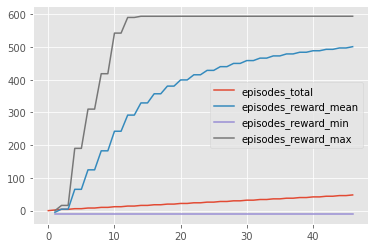

In [28]:
episodes_this_iter = df['episodes_this_iter']
episodes_total = df['episodes_total']
episodes_reward_mean = df['episode_reward_mean']
episodes_reward_max = df['episode_reward_max']
episodes_reward_min = df['episode_reward_min']

df_episodes = pd.DataFrame(episodes_total)
df_episodes['episodes_reward_mean'] = df['episode_reward_mean']
df_episodes["episodes_reward_min"] = df['episode_reward_min']
df_episodes["episodes_reward_max"] = df['episode_reward_max']

df_episodes.plot.line()

In [17]:
import ray.rllib.agents.dqn as dqn


checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(('episode_reward_mean'), mode='max'))

checkpoint_path = checkpoints[0][0]

# Restore agent
agent = dqn.DQNTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 0.01, #8e-6
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        'simple_optimizer': False
    }
)

agent.restore(checkpoint_path)

2021-10-20 19:40:29,984	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2021-10-20 19:40:29,984	INFO dqn.py:141 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2021-10-20 19:40:33,420	DEBUG rollout_worker.py:1363 -- Creating policy for default_policy
2021-10-20 19:40:33,425	DEBUG catalog.py:702 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f544664ab80>: Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf

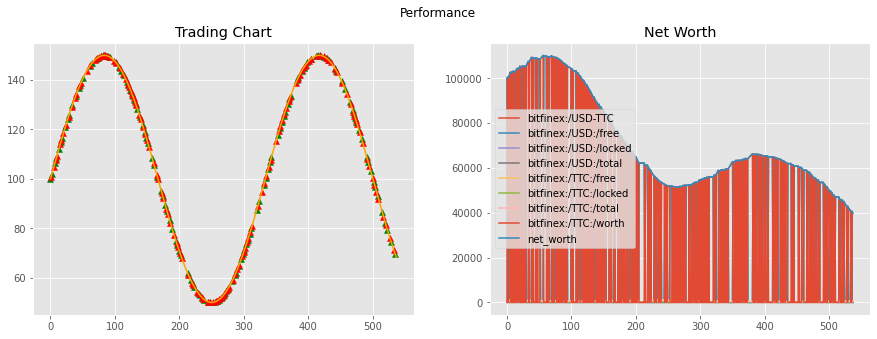

In [18]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    #action = agent.compute_action(obs)
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()